# Inspecting simulated supernova data at LSST DC2

**Author**:Laura Margarita Rodriguez Ortiz.

**Contributing authors**: Dr.Luis Henry Quiroga.

This notebook will illustrate the basics of supernova data and how to treat it, such as its light curves and sky coordinates.

**Learning objectives:** 
* Improve the access management data in the LSST project for the public.

* Supply a description of of what can be obtained from the data at LSST DC2.

## Before you start

In this notebook, the following files was download in the local machine, if you want direct access of those, you can transfer the DC2 Public Release data using [Globus](https://data.lsstdesc.org/doc/download).

* lsstdesc-public/dc2/run2.2i-dr6-v4/truth_sn/truth_sn_summary_v1-0-0.parquet
* lsstdesc-public/dc2/run2.2i-dr6-v4/truth_sn/truth_sn_variability_v1-0-0.parquet


## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd

In [2]:
from astropy.coordinates import SkyCoord 

In [3]:
import GCRCatalogs 
from GCRCatalogs.utils import first

In [4]:
import collections
from collections import OrderedDict

## Function Definition

In [5]:
def calculate_maxflux_per_bandpass(bandpass):
    '''
   Evaluation of peaks for each bandpass supernova to be analyzed, 
   with the condition that the point before and the point after the maximum 
   must have less magnitude than the maximum of each light curve described.
    '''
    g_g= grp.get_group(bandpass)
    
    bb= np.array(g_g['delta_flux'])
    aa=np.array(g_g['MJD'])
    
    
    maxindex= int(np.where(bb==np.max(bb))[0][0])
    if len(bb)<3 or bb[0]==bb[maxindex] or bb[-1]==bb[maxindex]:
        print('No peak for this sn in the band: ')
        print(bandpass)
        b_maxg= 0
        t_maxg= 0
        maxg= 0
        tmaxg= 0
        a_maxg= 0
        tp_maxg= 0
        duracion_ta_tp= 0
        duracion_ta_tmax= 0
        duracion_tmax_tp= 0
    else:
        b_maxg= bb[maxindex-1]
        t_maxg= aa[maxindex-1]
        maxg=bb[maxindex]
        tmaxg= aa[maxindex]
        a_maxg= bb[maxindex+1]
        tp_maxg= aa[maxindex+1]
        
        duracion_ta_tp= tp_maxg - t_maxg
        duracion_ta_tmax= tmaxg - t_maxg
        duracion_tmax_tp= tp_maxg - tmaxg
        
        print('For ', bandpass)
        print('Flux before max:', b_maxg, ', Peak flux: ', maxg, ', Post peak flux: ', a_maxg)
        print('MJD before max:', t_maxg, ', Peak MJD: ', tmaxg, ', Post peak MJD: ', tp_maxg )
    return maxg, tmaxg, t_maxg, tp_maxg, b_maxg, a_maxg, duracion_ta_tp, duracion_ta_tmax, duracion_tmax_tp


In [6]:
sn_name = input('Write the supernova ID: ')

Write the supernova ID: 7169215185942


In [7]:
sn= int(sn_name)

## Load supernovas catalogs and Data Frames

In [8]:
# Load catalogs from simulated data of supernovas, this bring us the caractherisitics that we could find for each supernova

sn_light_curve_cat = GCRCatalogs.load_catalog("desc_dc2_run2.2i_truth_sn_variability")
sn_light_curve_cat.list_all_quantities()

['delta_flux', 'MJD', 'bandpass', 'obsHistID', 'id', 'id_string']

In [9]:
#Load all the data of supernovas, we can visualice the head of all the data contained in the catalogs

d_lc = pd.DataFrame(first(sn_light_curve_cat.get_quantities(sn_light_curve_cat.list_all_quantities(), return_iterator=True)))
d_lc.head()

,delta_flux,bandpass,MJD,obsHistID,id,id_string
0,1761.107666,z,60753.011084,796369,10816002161686,MS_10199_0
1,1808.408447,z,60753.039172,796420,10816002161686,MS_10199_0
2,6543.662109,z,60754.996432,798153,10816002161686,MS_10199_0
3,3875.850098,y,60755.999051,799057,10816002161686,MS_10199_0
4,70788.859375,y,60767.990715,809099,10816002161686,MS_10199_0


In [10]:
# To choose only the features like Time, Bandpass, Flux for each ID, that is, for each supernova we want to work with,
# we can redefine the data frame, with d_lc[d_lc.id == sn].

d_lc = pd.DataFrame(sn_light_curve_cat.get_quantities(['MJD', 'bandpass', 'delta_flux', 'id']))
d_lc[d_lc.id == sn]
data_lc = d_lc[d_lc.id == sn]
data_lc.head()

,bandpass,delta_flux,MJD,id
20600877,i,0.673760,62034.375116,7169215185942
20600878,z,11.204701,62037.393094,7169215185942
20600879,r,1.420564,62038.238672,7169215185942
20600880,r,1.506814,62038.362723,7169215185942
20600881,r,1.507828,62038.364140,7169215185942


Text(0.5, 1.0, '7169215185942')

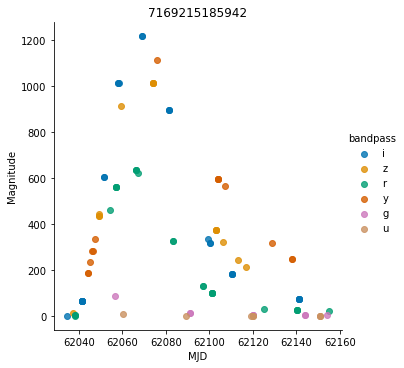

In [11]:
graphic=sns.lmplot(x='MJD', y='delta_flux', data=data_lc, hue='bandpass',palette='colorblind', fit_reg=(False))
graphic.set(xlabel = 'MJD', ylabel = 'Magnitude')
plt.title(sn)

## Calculations and development

It's important to remember that each supernova contains a different bandpass, in this order, each bandpass for one supernova, contains certain time and flow data.

In [12]:
#Selection of the flux for the entered ID
data_ran = data_lc.loc[:,['delta_flux','bandpass','MJD']]

In [13]:
grp = data_ran.groupby('bandpass')

In [14]:
filtros=list(set(data_ran['bandpass']))

In [15]:
maximos=[]
an_max=[]
pos_max=[]
tiempos_max=[]
ant_max=[]
post_max=[]
du_ta_tp= []
du_ta_tmax= []
du_tmax_tp= []
conteo_bandas= OrderedDict()

In [16]:
#Count of the supernovas that satisfy the conditions defined in the "Function Definition"
for i in filtros:
        conteo_bandas[i]= []

In [17]:
#Evaluation of the "Function Definition" for the supernova(s) for each bandpass
for i in filtros:    
        try:
            maxg, tmaxg, t_maxg, tp_maxg, b_maxg, a_maxg, duracion_ta_tp, duracion_ta_tmax, duracion_tmax_tp = calculate_maxflux_per_bandpass(i)
            maximos.append(maxg)
            tiempos_max.append(tmaxg)
            an_max.append(b_maxg)
            pos_max.append(a_maxg)
            ant_max.append(t_maxg)
            post_max.append(tp_maxg)
            du_ta_tp.append(duracion_ta_tp)
            du_ta_tmax.append(duracion_ta_tmax)
            du_tmax_tp.append(duracion_tmax_tp)
            conteo_bandas[i]= 1

        except:
            print("There's no band")  
            print(i)
            conteo_bandas[i]= 0

No muestra pico para esta sn en la banda: 
g
No muestra pico para esta sn en la banda: 
u
For  r
Flux before max: 561.0421 , Peak flux:  635.4861 , Post peak flux:  635.25275
MJD before max: 62057.201816 , Peak MJD:  62066.143618 , Post peak MJD:  62066.165885
For  y
Flux before max: 334.92606 , Peak flux:  1113.8737 , Post peak flux:  596.514
MJD before max: 62047.1973 , Peak MJD:  62076.12137 , Post peak MJD:  62104.04191
For  i
Flux before max: 1016.461 , Peak flux:  1217.8518 , Post peak flux:  1217.8408
MJD before max: 62058.187128 , Peak MJD:  62069.126772 , Post peak MJD:  62069.127674
For  z
Flux before max: 914.17926 , Peak flux:  1013.697 , Post peak flux:  1013.6892
MJD before max: 62059.379997 , Peak MJD:  62074.138109 , Post peak MJD:  62074.138557


## Results

To visualize the data obtained for the chosen supernova in an orderly manner, a new Data Frame is created, in which the data of the maximum points per bandpass and the elements that were defined in _"Function Definition"_.

In [21]:
df_max=pd.DataFrame()

In [22]:
df_max['Bandpass'] = filtros
df_max['Max.Delta_Flux'] = maximos
df_max['Max.MJD'] = tiempos_max
df_max['Flux_before'] = an_max
df_max['Flux_post'] = pos_max
df_max['Time_before'] = ant_max
df_max['Time_post'] = post_max
df_max['Before max - Post max']= du_ta_tp
df_max['Before max - Peak']= du_ta_tmax
df_max['Peak - Post max']=  du_tmax_tp
orden= df_max.sort_values('Max.Delta_Flux', ascending=False)
#Remove the values = 0
orden= orden.drop(df_max[df_max['Max.Delta_Flux']==0].index) 

#Table for the new data frame
print('Maximums for sn ID: ', sn_name)
orden.head()

Maximums for sn ID:  7169215185942


,Bandpass,Max.Delta_Flux,Max.MJD,Flux_before,Flux_post,Time_before,Time_post,Before max - Post max,Before max - Peak,Peak - Post max
4,i,1217.851807,62069.126772,1016.460999,1217.840820,62058.187128,62069.127674,10.940546,10.939644,0.000902
3,y,1113.873657,62076.121370,334.926056,596.513977,62047.197300,62104.041910,56.844610,28.924070,27.920540
5,z,1013.697021,62074.138109,914.179260,1013.689209,62059.379997,62074.138557,14.758560,14.758112,0.000448
2,r,635.486084,62066.143618,561.042114,635.252747,62057.201816,62066.165885,8.964069,8.941802,0.022267
